## Realtime tracking with HTC Vive tracker
### Requirement
* Get rnb-track project at the same directory as rnb-control
* Follow Instruction on rnb-track/ReadMe.md
* Install urdf_parser_py

```bash
pip install urdf_parser_py
```
* If python2 is used, openvr functions should be initialized and run on separate python3 program
  - PandaClient needs ROS; thus it should be run on python2, linux
  - To use with python2, install SharedArray
  ```
  pip install SharedArray
  pip3 install SharedArray
  ```

### Prepare tracker

In [1]:
import sys
if sys.version.startswith("3"):
    from utils.direct_vive import ViveTrackers
    tracks = ViveTrackers()
    tracks.init_vive()
else:
    from utils.shared_vive import SharedTrackers # linked to python3 with shared memory
    tracks = SharedTrackers()
    tracks.init_vive()

Found 2 Tracking References
  tracking_reference_1 (LHB-7C3E08C1, Mode Valve SR Imp, Valve SR Imp)
  tracking_reference_2 (LHB-7246D81D, Mode Valve SR Imp, Valve SR Imp)
Found 1 HMD
  hmd_1 (LHR-F67BA08F, VIVE_Pro MV)
Found 1 Controller
  controller_1 (LHR-C22319DF, VIVE Controller Pro MV)
Found 0 Trackers


In [2]:
dev_name = "controller_1"
# dev_name = "tracker_1"

### Get TrajectoryClient

In [3]:
from utils.trajectory_client.indy_trajectory_client import IndyTrajectoryClient
traj_client = IndyTrajectoryClient(server_ip="192.168.1.213")
urdf_path = "../urdf/indy7/indy7.urdf"

# from utils.trajectory_client.panda_trajectory_client import PandaTrajectoryClient
# traj_client = PandaTrajectoryClient(server_ip="192.168.21.14", robot_ip="192.168.21.13")
# urdf_path = "../urdf/panda/panda_bullet.urdf"

## Task trajectory generation

### Prepare urdf content

In [4]:
from urdf_parser_py.urdf import URDF
from utils.joint_utils import *
from utils.traj_utils import *

urdf_content = URDF.from_xml_file(urdf_path)
link_names = get_link_names(urdf_content)
joint_names = get_joint_names(urdf_content)
base_link, tip_link = link_names[0], link_names[-1]

### Set task space

In [5]:
from utils.algebra import *
## Calculate s-curve trajectory in task space
se3_alg = Combined([Euclidean(3), RotationUVW()])

### Run online tracking

In [6]:
DURATION = 30 #sec

In [7]:
## Set reference Q0, T0
Q0 = traj_client.get_qcur()
T0 = get_tf(tip_link, list2dict(Q0, joint_names), 
            urdf_content, from_link=base_link)
Tref = tracks.get_pose(tname=dev_name)
Tref_inv = np.linalg.inv(Tref)
P0 = np.concatenate([T0[:3,3], list(reversed(Rot2zyx(T0[:3,:3])))])
lpf_dp = LowPassFilter(1.0/traj_client.traj_freq, 2, np.zeros(6))

# stime = StrictTimer(1.0/traj_client.traj_freq)
dp_raw_list = []
dp_list = []
P_list = []
P1_pre = np.copy(P0)
Q_cur = np.copy(Q0)
Q_list = [Q_cur]
traj_client.start_tracking()
for _ in range(int(DURATION*traj_client.traj_freq)):
#     stime.sleep()
    Ttar = matmul_series(T0, Tref_inv, tracks.get_pose(dev_name))
    P1 = np.concatenate([Ttar[:3,3], list(reversed(Rot2zyx(Ttar[:3,:3])))])
    dp_raw = se3_alg.diff_in_alg(P1_pre, [P1])[0]
    dp = lpf_dp.update(dp_raw)
    se3_alg.add_from_alg(P1_pre, [dp])[0]
    P1_pre = P1
    
    J = get_jacobian(
        tip_link, urdf_content, Q_cur, joint_names, ref_link=base_link)
    Q_cur += np.matmul(np.linalg.pinv(J), dp)
    while not traj_client.push_Q(Q_cur, online=True):
        continue
    
    Q_list.append(np.copy(Q_cur))
    dp_raw_list.append(dp_raw)
    dp_list.append(dp)
    P_list.append(P1)
traj_client.stop_tracking()

Connect: Server IP (192.168.1.213)


{}

### plot trajectories

In [17]:
import matplotlib.pyplot as plt

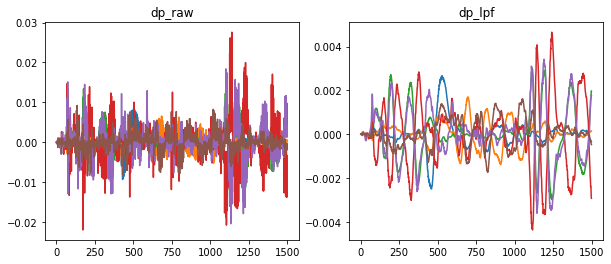

In [18]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("dp_raw")
plt.plot(dp_raw_list)
plt.subplot(1,2,2)
plt.title("dp_lpf")
plt.plot(dp_list)

Text(0.5, 1.0, 'Q')

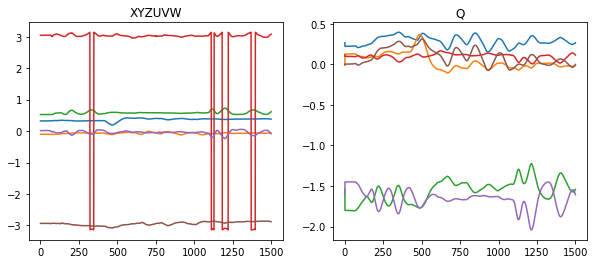

In [19]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(P_list)
plt.title("XYZUVW")
plt.subplot(1,2,2)
plt.plot(Q_list)
plt.title("Q")